In [4]:
import sys
sys.path.append("../")

# Get rid of annoying tf warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
from scipy.stats import beta, expon

from models import RandomWalkPoissonModel
from experiments import NeuralCoalMiningExperiment, BayesLoopCoalMiningExperiment
from data import coal_mining_data

In [16]:
# If set to False, existing results will be loaded
# Set to True if you want to re-run the experiments
TRAIN_NETWORKS = False
RUN_BAYESLOOP = False

# Neural Experiment

In [6]:
model = RandomWalkPoissonModel()

INFO:root:Performing 2 pilot runs with the poisson_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [7]:
neural_experiment = NeuralCoalMiningExperiment(model)

INFO:root:Loaded loss history from ../checkpoints/coal_mining/history_20.pkl.
INFO:root:Networks loaded from ../checkpoints/coal_mining/ckpt-20
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [8]:
if TRAIN_NETWORKS:
    history = neural_experiment.run(
        epochs=20, 
        iterations_per_epoch=1000, 
        batch_size=32
    )
else:
    history = neural_experiment.trainer.loss_history.get_plottable()

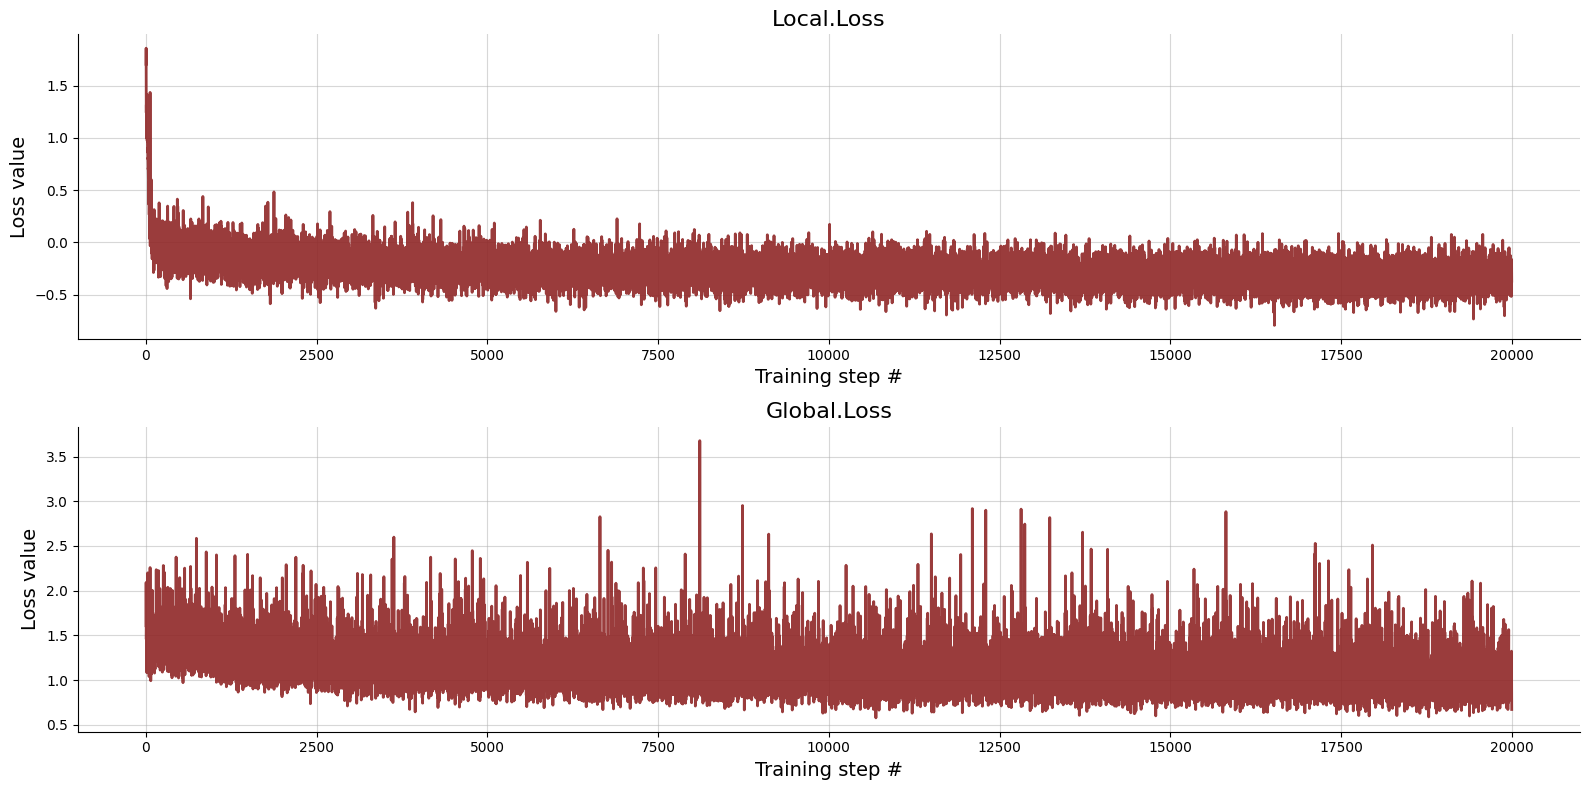

In [9]:
f = beef.diagnostics.plot_losses(history)

# BayesLoop Experiment

In [2]:
bayesloop_experiment = BayesLoopCoalMiningExperiment()

+ Created new study.
  --> Hyper-study
+ Observation model: Poisson. Parameter(s): ['accident_rate']
+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['sigma']


In [18]:
if RUN_BAYESLOOP:
    bl_post_means, bl_post_stds = bayesloop_experiment.run(coal_mining_data)
else:
    bl_post_means, bl_post_stds = bayesloop_experiment.load_results()

In [3]:
bl_post_means, bl_post_stds = bayesloop_experiment.run(coal_mining_data)

+ Successfully imported array.
+ Set hyper-prior(s): ['25*(1 - x)**24']
+ Started new fit.
    + 4000 analyses to run.


  0%|          | 0/4000 [00:00<?, ?it/s]

    + Computed average posterior sequence
    + Computed hyper-parameter distribution
    + Log10-evidence of average model: -76.68832
    + Computed local evidence of average model
    + Computed mean parameter values.
+ Finished fit.


# Evaluation

In [10]:
%%time
# Obtain samples
posterior_samples = neural_experiment.amortizer.sample(
    np.log1p(coal_mining_data["disasters"][None, :, None]), 4000
)

# Un-standardize parameters via prior mean and prior std
local_samples = posterior_samples["local_samples"] * expon.std(scale=1.0) + expon.mean(scale=1.0)
net_post_means = local_samples.mean(axis=0)
net_post_stds = local_samples.std(axis=0)

CPU times: user 2.5 s, sys: 667 ms, total: 3.17 s
Wall time: 1.05 s


In [14]:
EMPIRIC_COLOR = '#1F1F1F'
NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'

# set font type
import matplotlib
matplotlib.rcParams['font.serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "serif"

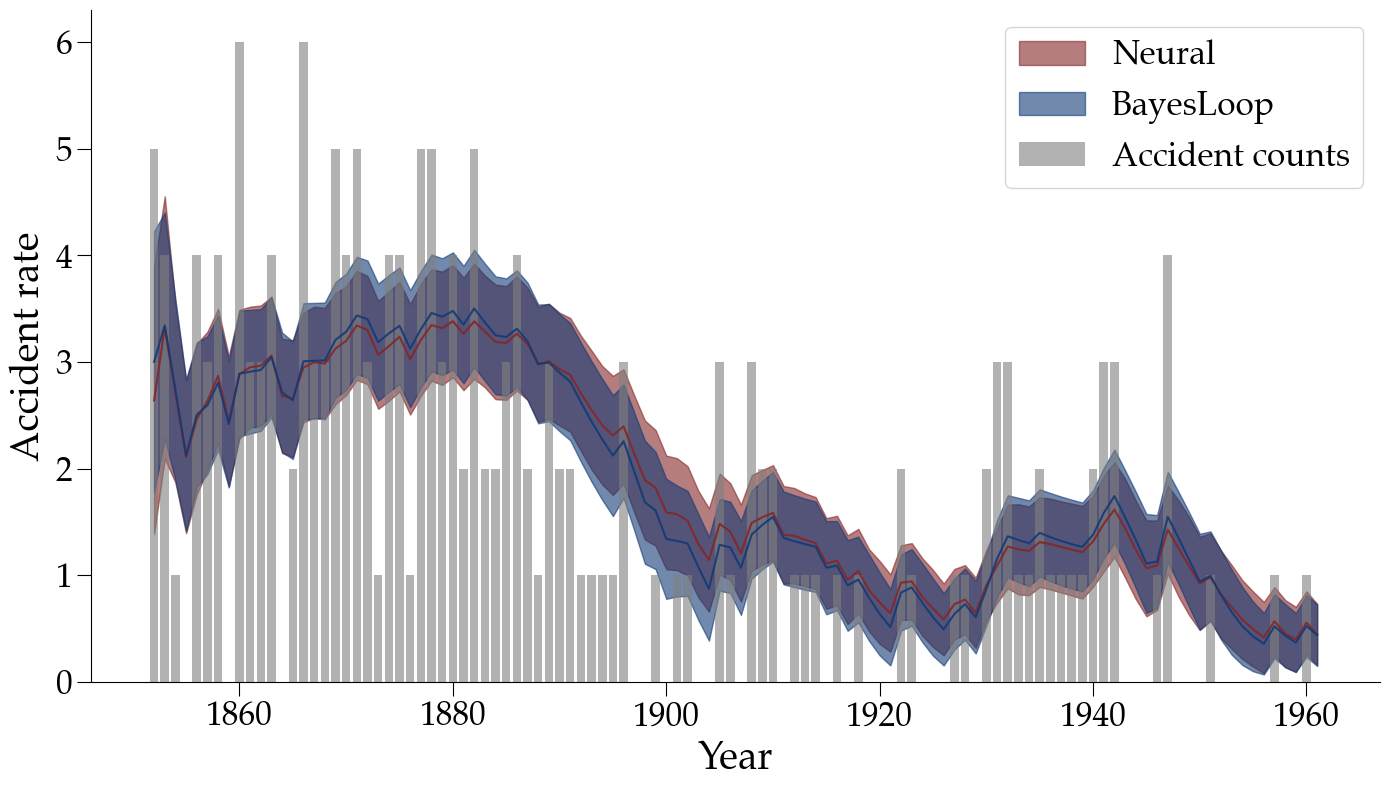

In [15]:
time = coal_mining_data["year"]
plt.figure(figsize=(14, 8))
plt.plot(time, net_post_means, alpha=0.9, color=NEURAL_COLOR)
plt.fill_between(
    time,
    net_post_means + net_post_stds,
    net_post_means - net_post_stds,
    alpha=0.6,
    label="Neural",
    edgecolor="none",
    color=NEURAL_COLOR
)

plt.plot(time, bl_post_means, alpha=0.9, color=COMPARISON_COLOR)
plt.fill_between(
    time,
    bl_post_means + bl_post_stds,
    bl_post_means - bl_post_stds,
    alpha=0.6,
    label='BayesLoop',
    edgecolor="none",
    color=COMPARISON_COLOR
)

plt.bar(
    time,
    coal_mining_data["disasters"],
    align="center",
    facecolor="gray",
    alpha=0.6,
    label="Accident counts",
)

plt.ylabel("Accident rate", fontsize=28)
plt.xlabel("Year", fontsize=28)
plt.tick_params(axis="both", which="major", length=10, labelsize=24)

plt.legend(fontsize=24)
sns.despine()
plt.tight_layout()

plt.savefig('../plots/coal_mining_benchmark.png', dpi=300)